# Prosta sieć neuronowa w TensorFlow
Czas połączyć wszystkie elementy. W tej sekcji:
* stworzymy wielowarstwowy model głębokiego uczenia
* wczytamy dane
* wytrenujemy i zweryfikujemy model<br>

Wprowadzimy też nowy krok:
* zapisywanie i wczytywanie wytrenowanego modelu

Naszym celem jest zbudowanie modelu, który potrafi sklasyfikować kwiat irysa na podstawie czterech cech. 

Jest to klasyfikacja wieloklasowa, w której każda próbka może należeć do JEDNEJ z 3 klas:

* <em>Iris setosa</em>,
* <em>Iris virginica</em>
* <em>Iris versicolor</em>).


Sieć będzie mieć 4 neurony wejściowe (wymiary kwiatu) i 3 neurony wyjściowe (wyniki). 

Funkcja straty porówna etykietę docelową (ground truth) z odpowiadającym jej wynikiem na wyjściu.


<div class="alert alert-info">

**UWAGA:**  
Przy klasyfikacjach wieloklasowych zwykle przekształcamy wektor etykiet w macierz zakodowaną one-hot.  

Jeśli 5 etykiet wygląda tak:

```python
tf.constant([0, 2, 1, 0, 1])
```

wówczas zakodujemy je następująco:

```python
tf.constant([[1, 0, 0], # 0
            [0, 0, 1], # 2
            [0, 1, 0], # 1
            [1, 0, 0], # 0
            [0, 1, 0]])# 1
```

To łatwo uzyskać funkcją [`tf.one_hot()`](https://www.tensorflow.org/api_docs/python/tf/one_hot).


In [1]:
import tensorflow as tf

In [2]:
etykiety = tf.constant([0, 2, 1, 0, 1], dtype=tf.int32)

tf.one_hot(etykiety, depth=3)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)>

W naszym przypadku funkcja straty [`tf.keras.losses.SparseCategoricalCrossentropy()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) zrobi to za nas.

</div>

## Wykonajmy standardowe importy


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Zdefiniujmy klasę modelu
W tym ćwiczeniu korzystamy ze zbioru danych irysów. Ponieważ pojedyncza prosta nie potrafi rozdzielić trzech gatunków, powinniśmy uwzględnić przynajmniej jedną warstwę ukrytą.

W metodzie `call` wykorzystamy funkcję <a href='https://en.wikipedia.org/wiki/Rectifier_(neural_networks)'>Rectified Linear Unit</a> (ReLU)<br>
$\quad f(x)=\max(0,x)$<br>
jako funkcję aktywacji. Jest ona dostępna jako warstwa [`keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) z parametrem `activation='relu'`.


In [4]:
class IrisModel(keras.Model):
    def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
        super().__init__()
        self.dense1 = layers.Dense(h1, activation='relu')
        self.dense2 = layers.Dense(h2, activation='relu')
        self.out = layers.Dense(out_features)  # logits, softmax doda funkcja straty

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.out(x)

Logits - surowe wyjścia ostatniej warstwy Dense. Nie są przepuszczone jeszcze przez funkcję aktywacji

In [5]:
# Utwórz instancję klasy IrisModel z domyślnymi parametrami:
tf.random.set_seed(32)
model = IrisModel()
# wymuś utworzenie wag
_ = model(tf.zeros((1, 4)))

## Wczytajmy zbiór danych irysów


In [6]:
df = pd.read_csv('../Data/iris.csv')
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


## Wykreślmy zbiór danych
Zbiór irysów zawiera 4 cechy. Aby zorientować się, jak się ze sobą korelują, narysujemy cztery ich wzajemne zależności.<br>
Skorzystamy z indeksów kolumn, aby pobrać ich nazwy parami: <tt>plots = [(0,1),(2,3),(0,2),(1,3)]</tt>.<br>
Para <tt>(0,1)</tt> odpowiada ustawieniu „sepal length (cm)” jako <tt>x</tt> oraz „sepal width (cm)” jako <tt>y</tt>.


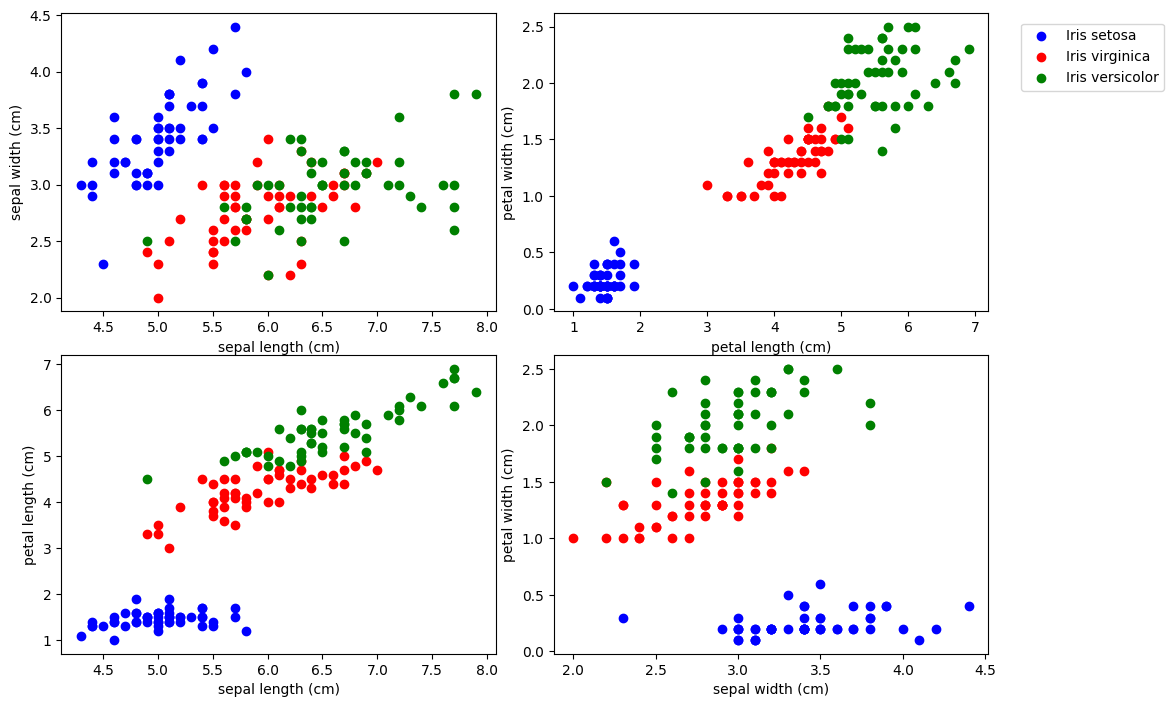

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['target']==j][x], df[df['target']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1,0.85))
plt.show()

## Przeprowadźmy Train/Test/Split


In [8]:
X = df.drop('target',axis=1).values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

## Przygotujmy `tf.data.Dataset`
W tej analizie nie musimy tworzyć osobnej klasy `Dataset`, ale warto skorzystać z modułu `tf.data`. Mimo że nasz zbiór jest niewielki (120 próbek treningowych), załadujemy go do modelu w dwóch partiach. Ta technika okazuje się niezwykle pomocna przy dużych zbiorach danych.

Zwróćmy uwagę, że scikit-learn potasował pierwotny zbiór jeszcze przed przygotowaniem zestawów treningowego i testowego. Mimo to warto skorzystać z opcji `shuffle`, jeśli będziemy wykonywać wiele przejść po zbiorze.


In [9]:
batch_size = 60
train_ds = (tf.data.Dataset
            .from_tensor_slices((X_train, y_train))
            .shuffle(buffer_size=len(X_train), seed=33)
            .batch(batch_size))

test_ds = (tf.data.Dataset
           .from_tensor_slices((X_test, y_test))
           .batch(batch_size))

## Zdefiniujmy funkcję straty i optymalizator

Wykorzystamy <a href='https://en.wikipedia.org/wiki/Cross_entropy'>entropię krzyżową</a> w wariancie [`tf.keras.losses.SparseCategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) z parametrem `from_logits=True`.

Jako optymalizatora zastosujemy odmianę stochastycznego spadku gradientowego <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam'>Adam</a> (skrót od Adaptive Moment Estimation), dostępną jako [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).


---

### 1. `loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)`

* **Funkcja straty** dla **klasyfikacji wieloklasowej**.
* „Sparse” oznacza, że etykiety (`y`) są zapisane jako **pojedyncze liczby całkowite** (np. `0, 1, 2`), a nie one-hot wektory.
* `from_logits=True` → model zwraca **surowe logity** (wynik warstwy gęstej, np. `[2.1, -0.5, 0.7]`) i w środku zostanie automatycznie zastosowany **softmax**.

Przykład:

* `y_true = 2` (klasa nr 2),
* `y_pred = [2.1, -0.5, 0.7]` (logity),
  funkcja straty policzy softmax + cross-entropy.

---

### 2. `optimizer = keras.optimizers.Adam(learning_rate=0.01)`

* Używamy **optymalizatora Adam** – bardzo popularnego, bo łączy adaptacyjne uczenie się (Adagrad) z momentum (RMSprop).
* `learning_rate=0.01` – szybkość uczenia.

  * Standardowo w Adam często stosuje się **0.001**,
  * tutaj ustawiono **0.01**, co oznacza agresywniejsze uczenie (większe kroki w aktualizacji wag).

---

### 👉 Podsumowanie

* `loss_fn` – mówi **jak mierzymy błąd modelu** (dla klasyfikacji wieloklasowej).
* `optimizer` – mówi **jak model ma uczyć się na podstawie gradientów** (Adam z LR=0.01).


Ustawmy też globalne ziarno generatora liczb losowych w TensorFlow.
Dzięki temu inicjalizacja wag w modelu i inne losowe operacje (np. shuffle w datasetach) będą powtarzalne → zawsze ten sam wynik przy ponownym uruchomieniu kodu.

In [10]:
tf.random.set_seed(4)

Stwórzmy instancję klasy modelu (IrisModel), który zdefiniowaliśmy wcześniej.

Na tym etapie model jest zdefiniowany, ale jeszcze nie ma zainicjalizowanych wag — dopóki nie „przepuścimy” przez niego danych.

In [11]:
model = IrisModel()

Stwórzmy tensor wejściowy wypełniony zerami o wymiarach (1, 4) — czyli 1 próbka, 4 cechy (dokładnie tyle co w Iris).

Wywołajmy model na tych danych, co wymusi inicjalizację wag i stworzenie warstw.

Wynik przypisujemy do `_` — to konwencja mówiąca, że nie będziemy później korzystać z tej zmiennej.


In [102]:
_ = model(tf.zeros((1, 4)))

## Wytrenujmy model

### custom training loop

To jest **ręczne trenowanie modelu**.

* Sami piszemy logikę: obliczanie strat, gradientów, aktualizację wag i zbieranie wyników.
* Daje to **pełną kontrolę** – możemy np. wstawić własne metryki, niestandardowe modyfikacje gradientów, inne sposoby aktualizacji wag.
* Wymaga za to więcej kodu i ostrożności.



In [137]:
# --- inicjalizacja ---
model_manual = IrisModel()
_ = model_manual(tf.zeros((1, 4)))   # rozgrzanie modelu

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam(learning_rate=0.01)

epochs = 50
losses = []

# --- pętla trenowania ---
for epoch in range(1, epochs + 1):
    epoch_loss = keras.metrics.Mean(name="epoch_loss")

    for batch_x, batch_y in train_ds:
        with tf.GradientTape() as tape:
            logits = model_manual(batch_x, training=True)
            loss_value = loss_fn(batch_y, logits)

        # oblicz i zastosuj gradienty
        grads = tape.gradient(loss_value, model_manual.trainable_variables)
        optimizer.apply_gradients(zip(grads, model_manual.trainable_variables))

        # zaktualizuj metrykę
        epoch_loss.update_state(loss_value)

    # zapisz wynik
    loss_float = epoch_loss.result().numpy()
    losses.append(loss_float)

    # log co 10 epok
    if epoch % 10 == 1:
        print(f"Epoch {epoch:2d} | Loss: {loss_float:.6f}")


2025-10-02 22:13:06.630059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:06.662742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:06.682631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:06.700933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:06.717793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:06.735575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:06.753179: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch  1 | Loss: 1.452817
Epoch 11 | Loss: 0.844399


2025-10-02 22:13:06.843105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:06.875498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:06.894871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:06.912477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:06.929525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:06.947981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:06.965444: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 21 | Loss: 0.456595
Epoch 31 | Loss: 0.321584


2025-10-02 22:13:07.057538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:07.076937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:07.095319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:07.115759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:07.135583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:07.155052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:07.175956: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 41 | Loss: 0.197543


2025-10-02 22:13:07.495107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:07.514844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:07.532246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:07.549997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:07.569101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 22:13:07.587515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Wykres funkcji straty


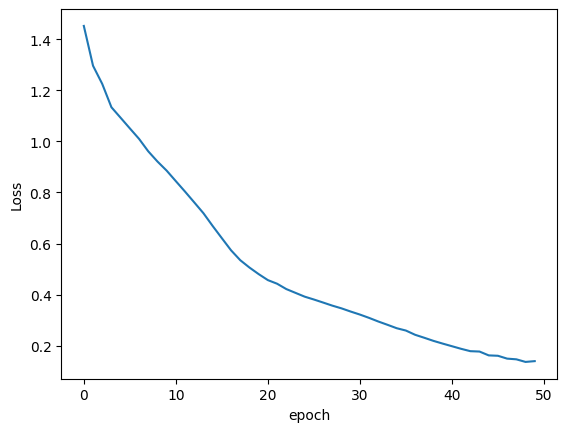

In [138]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

### Automatycznie — `fit`

To jest **wysokopoziomowe API Keras** – framework wykonuje cały proces za nas.

* Automatycznie oblicza loss, gradienty, aktualizuje wagi i zbiera metryki.
* To krótsze i wygodniejsze, jeśli nie musimy ingerować w szczegóły.


In [139]:
# tworze nową instancję modelu by zacząć od początku to trenowanie
model1 = IrisModel()
_ = model1(tf.zeros((1, 4)))


model1.compile(loss=loss_fn, metrics=["accuracy"])  # domyślny optimizer to RMSprop
history1 = model1.fit(train_ds, epochs=50)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6000 - loss: 1.0688  
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6500 - loss: 1.0296
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6500 - loss: 1.0110
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6500 - loss: 0.9943
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6500 - loss: 0.9806
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6500 - loss: 0.9680
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6500 - loss: 0.9551
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6500 - loss: 0.9431
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6500 - loss: 0.9324
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6500 - loss: 0.9206
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6500 - loss: 0.9101
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6500 - loss: 0.8998
Epoch 13/50

In [140]:
# tworze nową instancję modelu by zacząć od początku to trenowanie
model2 = IrisModel()
_ = model1(tf.zeros((1, 4)))

optimizer = keras.optimizers.Adam(learning_rate=0.01)  # 0.01 to dobry wybór
model2.compile(loss=loss_fn, metrics=["accuracy"], optimizer=optimizer)  # bo domyślny optimizer to RMSprop
history2 = model2.fit(train_ds, epochs=50)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3500 - loss: 1.8454  
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3500 - loss: 1.3919
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3500 - loss: 1.1946
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3500 - loss: 1.0977
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3500 - loss: 1.0477
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3833 - loss: 1.0244
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4167 - loss: 1.0067
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3083 - loss: 0.9799
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4333 - loss: 0.9460
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6417 - loss: 0.9069
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6750 - loss: 0.8650
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8250 - loss: 0.8228
Epoch 13/50

#### Wykres funkcji straty

Metryki przechowujemy w obiekcie historii zwracanym przez `model.fit()`.


In [141]:

print(history.history.keys())
# np. dict_keys(['loss', 'accuracy'])

print(history.history['loss'][:5])      # pierwsze 5 wartości straty
print(history.history['accuracy'][:5])  # pierwsze 5 wartości accuracy

dict_keys(['accuracy', 'loss'])
[1.280225396156311, 1.2405962944030762, 1.2190823554992676, 1.200263500213623, 1.1847211122512817]
[0.3499999940395355, 0.3499999940395355, 0.3499999940395355, 0.3499999940395355, 0.3499999940395355]


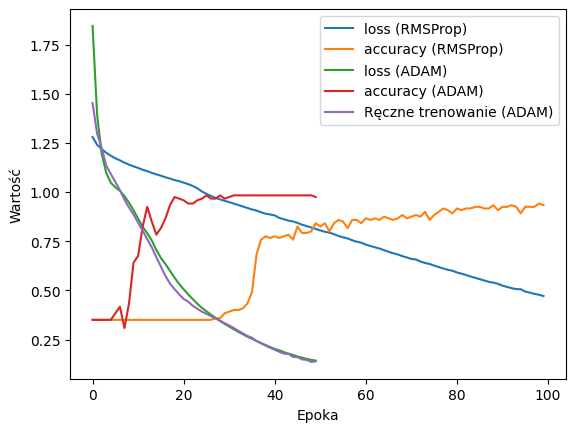

In [142]:

plt.plot(history.history['loss'], label='loss (RMSProp)')
plt.plot(history.history['accuracy'], label='accuracy (RMSProp)')
plt.plot(history2.history['loss'], label='loss (ADAM)')
plt.plot(history2.history['accuracy'], label='accuracy (ADAM)')
plt.plot(range(epochs), losses, label="Ręczne trenowanie (ADAM)")


plt.xlabel("Epoka")
plt.ylabel("Wartość")
plt.legend()
plt.show()


## Weryfikujemy model
Teraz przepuścimy zbiór testowy przez model, aby sprawdzić, czy obliczona strata przypomina tę z danych treningowych.


In [143]:
# ABY OCENIĆ CAŁY ZBIÓR TESTOWY
# menedżer kontekstu nie jest potrzebny, ale dla przejrzystości działa bez gradientów
test_logits = model_manual(tf.constant(X_test), training=False)
loss = loss_fn(y_test, test_logits).numpy()
print(f'{loss:.8f}')  # 0.4-0.7

0.18232849


In [145]:
# ABY OCENIĆ CAŁY ZBIÓR TESTOWY
# menedżer kontekstu nie jest potrzebny, ale dla przejrzystości działa bez gradientów
test_logits = model1(tf.constant(X_test), training=False)
loss = loss_fn(y_test, test_logits).numpy()
print(f'{loss:.8f}')  # 0.4-0.7

0.59463233


In [146]:
# ABY OCENIĆ CAŁY ZBIÓR TESTOWY
# menedżer kontekstu nie jest potrzebny, ale dla przejrzystości działa bez gradientów
test_logits = model2(tf.constant(X_test), training=False)
loss = loss_fn(y_test, test_logits).numpy()
print(f'{loss:.8f}')  # 0.4-0.7

0.15257543


In [136]:
import numpy as np
import tensorflow as tf

# Kody kolorów ANSI
RED = '\033[91m'
GREEN = '\033[92m'
RESET = '\033[0m'  # przywróć domyślny kolor


def predict(model, X):
    """
    Zwraca logity, prawdopodobieństwa (softmax) i predykcje klas.
    """
    logits = model(tf.constant(X), training=False).numpy()
    probs = tf.nn.softmax(logits, axis=1).numpy()
    preds = np.argmax(logits, axis=1)
    return logits, probs, preds


def evaluate_and_print(model, X, y):
    """
    Wyświetla wyniki predykcji z kolorowym oznaczeniem poprawności.
    """
    logits, probs, preds = predict(model, X)
    correct = 0

    for i, (logit_row, prob_row, pred_val, actual) in enumerate(zip(logits, probs, preds, y), start=1):
        is_correct = int(actual) == pred_val
        color = GREEN if is_correct else RED

        logit_str = ', '.join(f"{v:7.3f}" for v in logit_row)
        prob_str = ', '.join(f"{p:7.3f}" for p in prob_row)

        print(f"{i:2}. logits=[{logit_str}] probs=[{prob_str}] "
              f"predicted: {pred_val} actual: {int(actual)} {color}{is_correct}{RESET}")

        if is_correct:
            correct += 1

    print(f"\n{correct} out of {len(y)} = {100 * correct / len(y):.2f}% correct")


# użycie
evaluate_and_print(model_manual, X_test, y_test)


 1. logits=[  0.096,   5.843,   3.176] probs=[  0.003,   0.932,   0.065] predicted: 1 actual: 1 True
 2. logits=[  0.674,   6.786,   2.957] probs=[  0.002,   0.977,   0.021] predicted: 1 actual: 1 True
 3. logits=[  9.402,   5.032,  -6.247] probs=[  0.988,   0.012,   0.000] predicted: 0 actual: 0 True
 4. logits=[ -0.535,   6.117,   4.189] probs=[  0.001,   0.872,   0.127] predicted: 1 actual: 1 True
 5. logits=[ -2.812,   4.749,   6.655] probs=[  0.000,   0.129,   0.871] predicted: 2 actual: 2 True
 6. logits=[ -4.624,   4.264,   9.044] probs=[  0.000,   0.008,   0.992] predicted: 2 actual: 2 True
 7. logits=[  9.300,   5.111,  -6.093] probs=[  0.985,   0.015,   0.000] predicted: 0 actual: 0 True
 8. logits=[ 10.435,   5.385,  -6.940] probs=[  0.994,   0.006,   0.000] predicted: 0 actual: 0 True
 9. logits=[ -2.559,   5.150,   6.697] probs=[  0.000,   0.175,   0.825] predicted: 2 actual: 2 True
10. logits=[ -3.423,   5.088,   8.010] probs=[  0.000,   0.051,   0.949] predicted: 2 actua

In [147]:
evaluate_and_print(model1, X_test, y_test)

 1. logits=[ -0.264,   0.401,   0.487] probs=[  0.197,   0.384,   0.418] predicted: 2 actual: 1 False
 2. logits=[ -0.168,   0.384,   0.485] probs=[  0.215,   0.373,   0.413] predicted: 2 actual: 1 False
 3. logits=[  1.756,   0.589,  -2.010] probs=[  0.749,   0.233,   0.017] predicted: 0 actual: 0 True
 4. logits=[ -0.362,   0.410,   0.722] probs=[  0.163,   0.354,   0.483] predicted: 2 actual: 1 False
 5. logits=[ -0.647,   0.513,   0.974] probs=[  0.108,   0.345,   0.547] predicted: 2 actual: 2 True
 6. logits=[ -0.768,   0.553,   1.186] probs=[  0.085,   0.317,   0.598] predicted: 2 actual: 2 True
 7. logits=[  1.667,   0.578,  -1.905] probs=[  0.733,   0.247,   0.021] predicted: 0 actual: 0 True
 8. logits=[  2.161,   0.667,  -2.454] probs=[  0.810,   0.182,   0.008] predicted: 0 actual: 0 True
 9. logits=[ -0.676,   0.509,   1.028] probs=[  0.102,   0.335,   0.563] predicted: 2 actual: 2 True
10. logits=[ -0.681,   0.457,   1.221] probs=[  0.092,   0.288,   0.619] predicted: 2 ac

In [150]:
evaluate_and_print(model2, X_test, y_test)

 1. logits=[  0.420,   5.162,   3.084] probs=[  0.008,   0.882,   0.110] predicted: 1 actual: 1 True
 2. logits=[  0.733,   5.736,   2.450] probs=[  0.006,   0.958,   0.036] predicted: 1 actual: 1 True
 3. logits=[  4.550,   0.568,  -4.973] probs=[  0.982,   0.018,   0.000] predicted: 0 actual: 0 True
 4. logits=[  0.313,   5.468,   3.897] probs=[  0.005,   0.824,   0.171] predicted: 1 actual: 1 True
 5. logits=[ -0.511,   5.328,   7.390] probs=[  0.000,   0.113,   0.887] predicted: 2 actual: 2 True
 6. logits=[ -0.765,   5.387,   8.670] probs=[  0.000,   0.036,   0.964] predicted: 2 actual: 2 True
 7. logits=[  4.388,   1.011,  -4.703] probs=[  0.967,   0.033,   0.000] predicted: 0 actual: 0 True
 8. logits=[  5.213,   0.206,  -5.682] probs=[  0.993,   0.007,   0.000] predicted: 0 actual: 0 True
 9. logits=[ -0.323,   5.510,   6.821] probs=[  0.001,   0.212,   0.787] predicted: 2 actual: 2 True
10. logits=[ -0.497,   5.567,   7.681] probs=[  0.000,   0.108,   0.892] predicted: 2 actua

## Zapiszmy wytrenowany model do pliku
W tej chwili obiekt <strong><tt>model</tt></strong> został wytrenowany i zweryfikowany, a irysy klasyfikuje poprawnie w ~97% przypadków. Zapiszmy go na dysk. Korzystamy z metod [`model.save_weights()`](https://www.tensorflow.org/guide/keras/save_and_serialize#saving_weights_only) oraz [`model.load_weights()`](https://www.tensorflow.org/guide/keras/save_and_serialize#restoring_weights).

Istnieją dwie podstawowe metody zapisu modelu.

Pierwsza zapisuje i wczytuje tylko wagi (wyuczone parametry) modelu. Schemat wygląda tak:<br>
<tt><strong>Zapis:</strong>&nbsp;model.save_weights(PATH)<br><br>
<strong>Odczyt:</strong>&nbsp;model = TheModelClass(*args, **kwargs)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model(tf.zeros((1, 4)))  # wymuś budowę<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.load_weights(PATH)<br></tt>

Druga metoda zapisuje cały model (architekturę, wagi i optymalizator) przy pomocy [`model.save()`](https://www.tensorflow.org/guide/keras/save_and_serialize#saving_the_entire_model). Jeśli chcemy wczytać go w innym notatniku, upewnijmy się, że potrzebne dane również są dostępne.<br>
<tt><strong>Zapis:</strong>&nbsp;model.save(PATH)<br><br>
<strong>Odczyt:</strong>&nbsp;model = keras.models.load_model(PATH)<br></tt>

W obu przypadkach uruchamiamy model z parametrem `training=False`, aby warstwy działały w trybie inferencji i zapewniały spójne wyniki.

Więcej informacji znajdziemy w przewodniku https://www.tensorflow.org/guide/keras/save_and_serialize


### Zapiszmy model


In [151]:
model_manual.save_weights('IrisDatasetModel.weights.h5')

### Wczytajmy nowy model
Załadujmy nowy obiekt modelu i przetestujmy go tak jak wcześniej, aby upewnić się, że wszystko działa.


In [152]:
new_model = IrisModel()
_ = new_model(tf.zeros((1, 4)))
new_model.load_weights('IrisDatasetModel.weights.h5')

In [153]:
test_logits = new_model(tf.constant(X_test), training=False)
loss = loss_fn(y_test, test_logits).numpy()
print(f'{loss:.8f}')

0.18232849


## Zastosujmy model, aby sklasyfikować nowe, nieznane dane


In [154]:
mystery_iris = tf.constant([5.6, 3.7, 2.2, 0.5], dtype=tf.float32)

Zaznaczmy tego nowego irysa na żółto, aby zobaczyć, gdzie wypada względem pozostałych:


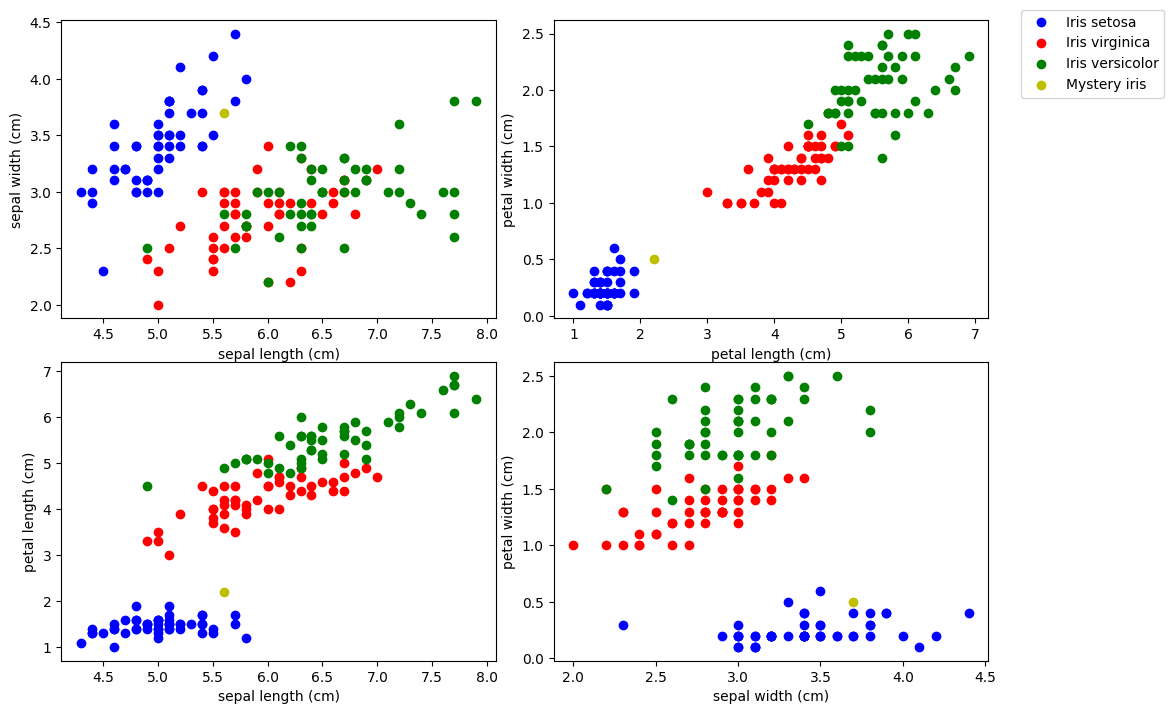

In [155]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor','Mystery iris']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['target']==j][x], df[df['target']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

    # Dodaj wykres naszego tajemniczego irysa:
    ax.scatter(float(mystery_iris[plots[i][0]]), float(mystery_iris[plots[i][1]]), color='y')

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

Teraz przepuśćmy tajemniczego irysa przez model:


In [156]:
logits = new_model(mystery_iris[tf.newaxis, :], training=False)
print(logits)
print()
print(labels[int(tf.argmax(logits, axis=1).numpy()[0])])

tf.Tensor([[ -0.23277694  -3.9255126  -14.954891  ]], shape=(1, 3), dtype=float32)

Iris setosa


## Świetna robota!
